In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup_max_slope(
    js_dists: List[float], min_slope_threshold: float = 0.02
):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def plot_heatmap_feature_acts(feature_activations, js_dists):
    # Assuming feature_activations is a PyTorch tensor
    feature_acts_np = (
        feature_activations.numpy()
    )  # Convert to numpy if it's not already

    # Identify top features from start and end
    n_top = 10
    start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
    end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

    # Assume js_blowup_step is the time step where JS distance starts increasing rapidly
    js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

    # Combine and get unique features
    combined_features = np.unique(
        np.concatenate([start_top_features, end_top_features])
    )

    # Create labels for y-axis
    y_labels = []

    feature_ranks = []

    for feat in combined_features:
        start_rank = np.where(start_top_features == feat)[0]
        end_rank = np.where(end_top_features == feat)[0]
        feature_rank = 0

        label = f"F{feat}"
        if len(start_rank) > 0:
            label += f" (S-{start_rank[0]+1})"
            feature_rank += start_rank[0]
        else:
            feature_rank += n_top

        if len(end_rank) > 0:
            label += f" (E-{end_rank[0]+1})"
            if len(start_rank) == 0:
                feature_rank += 10 + end_rank[0]

        y_labels.append(label)
        feature_ranks.append(feature_rank)

    sorted_feature_ranks = np.argsort(feature_ranks)
    sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
    sns.heatmap(
        feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
        cmap="coolwarm",
        cbar_kws={"label": "Activation"},
        yticklabels=sorted_y_labels,
        ax=ax,
    )

    # Add vertical line for JS distance blowup
    ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

    # Add text annotation for the JS blowup line
    ax.text(
        js_blowup_step,
        len(combined_features) - 0.25,
        "JS Dist Blowup",
        rotation=90,
        va="bottom",
        ha="right",
        color="white",
        fontweight="normal",
    )

    # Assuming js_distances is your array of JS distances over time
    ax2 = ax.twinx()
    ax2.plot(js_dists, color="white", linewidth=2)
    ax2.set_ylabel("JS Distance", color="white")
    ax2.tick_params(axis="y", labelcolor="white")

    plt.title("Top Feature Activations Over Time (Start and End)")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature ID (Start Rank, End Rank)")
    plt.tight_layout()
    plt.show()


def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    feature_acts = get_feature_activations(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Load & Clean data

In [5]:
metadata, activations = [], []

n_files = 5

for path in sorted(glob("observations/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [6]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

In [7]:
# Clean data
clean_metadata = []
clean_activations = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

max_recon_error = 3.0
c = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    js_dists = [s["js_dist"] for s in m["steps_metadata"]]

    if js_dists[-1] - js_dists[0] < 0.1:
        continue

    if np.isnan(js_dists).sum() > 1:
        continue

    act_recon = sae.decode(sae.encode(torch.tensor(acts[0])))
    recon_error = torch.tensor(acts[0]) - act_recon
    recon_error = recon_error.abs().sum(dim=-1).detach().numpy()

    if recon_error > max_recon_error:
        continue

    clean_metadata.append(m)
    clean_activations.append(acts)

    c += 1

    if c % 500 == 0:
        print(c)

clean_activations = np.stack(clean_activations)

500
1000
1500
2000
2500
3000


In [8]:
len(clean_metadata), clean_activations.shape

(3392, (3392, 100, 768))

In [9]:
metadata = clean_metadata
activations = clean_activations

In [13]:
data = []

n_examples = len(metadata)  # min(100, len(metadata))
# idxs = random.sample(range(len(metadata)), n_examples)
idxs = range(n_examples)

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    data.append({"js_dists": step_js_dists, "blowup_step": js_blowup_step, "idx": idx})

df = pd.DataFrame(data)

In [14]:
early_blowup_idxs = df.sort_values(by="blowup_step").head(10).index.tolist()

random_blowup_idxs = df.sample(10).index.tolist()

In [15]:
df.sort_values(by="blowup_step").head(10)

,js_dists,blowup_step,idx
1848,"[0.0004, 0.0576, 0.1223, 0.1671, 0.1958, 0.216...",2,1848
1044,"[0.0004, 0.0048, 0.0095, 0.0141, 0.0186, 0.023...",21,1044
1592,"[0.0003, 0.0058, 0.0117, 0.0177, 0.0239, 0.030...",29,1592
2196,"[0.0003, 0.0062, 0.0122, 0.0181, 0.0239, 0.029...",30,2196
2690,"[0.0004, 0.0023, 0.0044, 0.0065, 0.0086, 0.010...",31,2690
1296,"[0.0002, 0.0017, 0.0033, 0.005, 0.0067, 0.0084...",31,1296
566,"[0.0004, 0.0022, 0.0044, 0.0065, 0.0087, 0.010...",32,566
67,"[0.0002, 0.0051, 0.0103, 0.0155, 0.0209, 0.026...",32,67
1506,"[0.0004, 0.0057, 0.0116, 0.0178, 0.0242, 0.030...",32,1506
965,"[0.0002, 0.0069, 0.0137, 0.0205, 0.0274, 0.034...",32,965


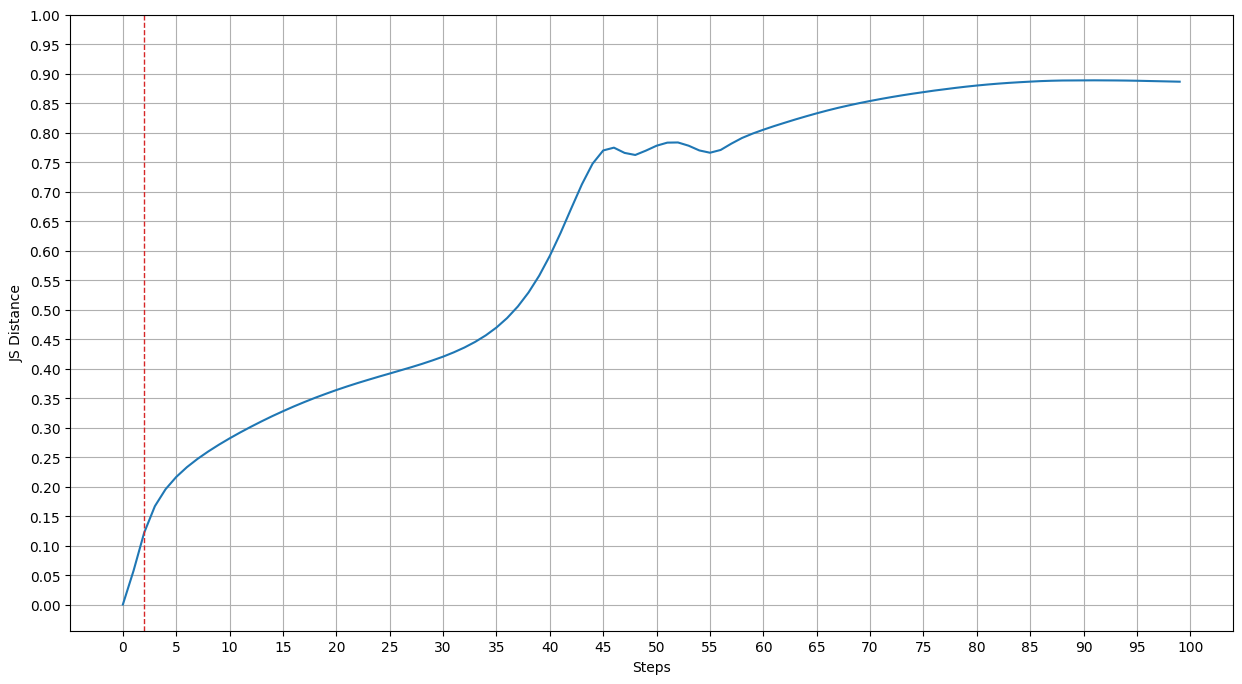

In [18]:
plt.figure(figsize=(15, 8))

# plt.axvline(x=pred, color="tab:green", linestyle="--", linewidth=1, label="pred")

for idx in early_blowup_idxs[0:1]:
    step_js_dists = df.loc[idx].js_dists
    js_blowup_step = df.loc[idx].blowup_step
    plt.plot(step_js_dists)

    plt.axvline(
        x=js_blowup_step, color="tab:red", linestyle="--", linewidth=1, label="blowup"
    )

plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 105, 5))
plt.xlabel("Steps")
plt.ylabel("JS Distance")
# plt.legend(loc="lower right")
plt.grid()
plt.show()

In [40]:
steps = list(range(len(step_js_dists)))

slopes = []
for i in range(1, len(steps)):
    dy = step_js_dists[i] - step_js_dists[i - 1]
    dx = steps[i] - steps[i - 1]
    slopes.append(dy / dx if dx != 0 else 0)

# Pad the beginning of slopes list to match the length of steps
slopes = [slopes[0]] + slopes

In [41]:
find_js_dist_blowup_max_slope(step_js_dists)

[nan, nan, 0.009, 0.0092, 0.0092, 0.009399999999999999, 0.009400000000000006, 0.009500000000000001, 0.009599999999999997, 0.009599999999999997, 0.0097, 0.0097, 0.009800000000000003, 0.009800000000000003, 0.00979999999999999, 0.009700000000000014, 0.009800000000000003, 0.009699999999999986, 0.009700000000000014, 0.009599999999999997, 0.009599999999999997, 0.00949999999999998, 0.00940000000000002, 0.009199999999999986, 0.009200000000000014, 0.009099999999999997, 0.009000000000000008, 0.008800000000000002, 0.008699999999999986, 0.008599999999999997, 0.008500000000000008, 0.008299999999999974, 0.00820000000000004, 0.008199999999999985, 0.008000000000000007, 0.007899999999999963, 0.007800000000000029, 0.007699999999999985, 0.007599999999999996, 0.007500000000000007, 0.007500000000000007, 0.007400000000000018, 0.007399999999999962, 0.007300000000000029, 0.007299999999999973, 0.00720000000000004, 0.007199999999999984, 0.007299999999999973, 0.00720000000000004, 0.007199999999999984, 0.00719999

16

In [46]:
any(np.array(slopes) > 0.05)

False

In [33]:
np.argsort(np.nan_to_num(slopes))[::-1][0]

16

In [ ]:
steps = list(range(len(js_dists)))

slopes = []
for i in range(1, len(steps)):
    dy = js_dists[i] - js_dists[i - 1]
    dx = steps[i] - steps[i - 1]
    slopes.append(dy / dx if dx != 0 else 0)

# Pad the beginning of slopes list to match the length of steps
slopes = [slopes[0]] + slopes
print(slopes)
return np.argsort(np.nan_to_num(slopes))[::-1][0]